# House Price Prediction

<p><b>Status: <span style=color:green;>Completed</span></b></p>

##### LOAD THE FEATURE DATA

In [1]:
import pandas as pd
import numpy as np

# like in math, these will be the 'X' variables
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
            'RM', 'AGE', 'DIS', 'RAD', 'TAX',
            'PTRATIO', 'B', 'LSTAT']

# this will be 'Y', or the dependent variable
target = 'MEDV'

# List all columns
columns = features + [target]

# read dataset and make a table
X = pd.read_csv('../../data/housing.data', names=columns, sep='\s+', header=None)
X.head()     # preview the first 5 rows

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


C:\Users\gerardo_paniagua\.conda\envs\vision\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\gerardo_paniagua\.conda\envs\vision\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


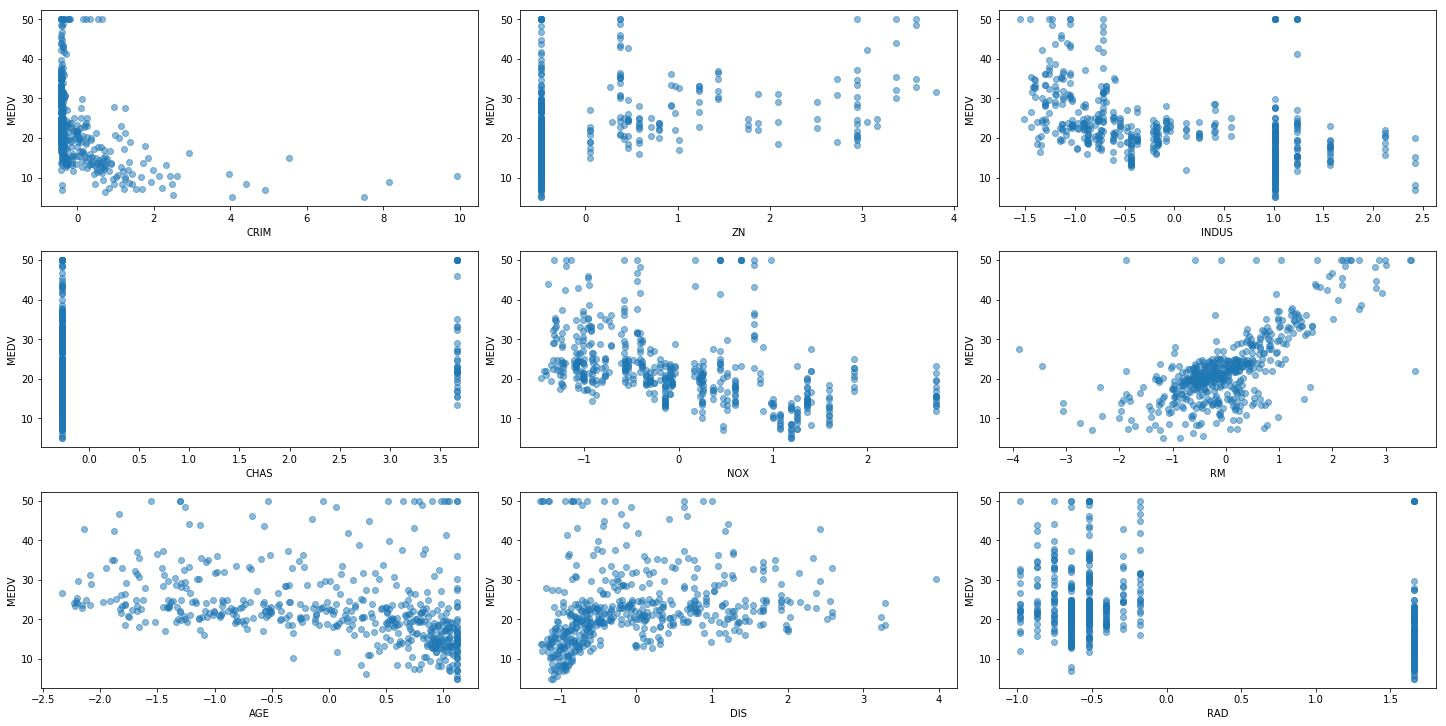

In [2]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# separate feature and target values
y = X[target].values.reshape(-1,1)
X = X.drop(columns=[target])


# apply standarization to the feature values
scaler = StandardScaler()
scaler = scaler.fit(X)
X[:] = scaler.transform(X)

# plot with various axes scales
rows = 3 ; cols = 3
f, ax = plt.subplots(rows, cols, figsize=(20,10))

for _row in range(rows):
    for _col in range(cols):
        col_name = X.columns[(_row*cols) + _col]
        ax[_row, _col].scatter(X[col_name], y, alpha=0.5)
        ax[_row, _col].set_xlabel(col_name)
        ax[_row, _col].set_ylabel(target)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

##### SPLIT THE DATA

In [3]:
from sklearn.model_selection import train_test_split

# set the seed for reproducibility
np.random.seed(127)

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=13)

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(X_train.shape,
                                                                    y_train.shape,
                                                                    X_test.shape,
                                                                    y_test.shape))

Data shapes:

X_train : (404, 13)
y_train : (404, 1)

X_test : (102, 13)
y_test : (102, 1)


##### DEFINE NETWORK PARAMETERS

In [4]:
# define number of attributes
n_features = X_train.shape[1]
n_target = 1  # quantitative data

# count number of samples in each set of data
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# define amount of neurons
n_layer_in = n_features # 13 neurons in input layer
n_layer_h1 = 5          # first  hidden layer
n_layer_h2 = 5          # second hidden layer
n_layer_out = n_target  # 1 neurons in output layer

sigma_init = 0.01   # For randomized initialization

##### MODEL ARCHITECTURE

In [5]:
import tensorflow as tf

# create symbolic variables
X = tf.placeholder(tf.float32, [None, n_layer_in], name="input")
Y = tf.placeholder(tf.float32, [None, n_layer_out], name="output")

# deploy the variables that will store the weights
W = {
    'W1': tf.Variable(tf.random_normal([n_layer_in, n_layer_h1], stddev = sigma_init), name='W1'),
    'W2': tf.Variable(tf.random_normal([n_layer_h1, n_layer_h2], stddev = sigma_init), name='W2'),
    'W3': tf.Variable(tf.random_normal([n_layer_h2, n_layer_out], stddev = sigma_init), name='W3')
}

# deploy the variables that will store the bias
b = {
    'b1': tf.Variable(tf.random_normal([n_layer_h1]), name='b1'),
    'b2': tf.Variable(tf.random_normal([n_layer_h2]), name='b2'),
    'b3': tf.Variable(tf.random_normal([n_layer_out]), name='b3')
}

# this will create the model architecture and output the result
def model_MLP(_X, _W, _b):
    with tf.name_scope('hidden_1'):
        layer_h1 = tf.nn.selu(tf.add(tf.matmul(_X,_W['W1']), _b['b1']))
    with tf.name_scope('hidden_2'):
        layer_h2 = tf.nn.selu(tf.add(tf.matmul(layer_h1,_W['W2']), _b['b2']))
    with tf.name_scope('layer_output'):
        layer_out = tf.add(tf.matmul(layer_h2,_W['W3']), _b['b3'])
        return layer_out   # these are the predictions

with tf.name_scope("MLP"):
    y_pred = model_MLP(X, W, b)

##### DEFINE MODEL CONFIGURATION

In [6]:
learning_rate = 0.4

with tf.name_scope("loss"):
    loss = tf.square(Y - y_pred) 
    loss = tf.reduce_mean(loss, name='MSE')
    
with tf.name_scope("train"):
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

##### EXECUTE THE MODEL

In [7]:
# define some parameters
n_epochs = 40
display_epoch = 2   # checkpoint will also be created based on this
batch_size = 10
n_batches = int(n_train/batch_size)

# store the results through every epoch iteration
mse_train_list = []
mse_test_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    for epoch in range(n_epochs):
        for i in range(0, n_train, batch_size):
            # create batches
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # improve the model
            _ = sess.run(training_op, feed_dict={X:X_batch, Y:y_batch})
            
        # measure performance and display the results
        if (epoch+1) % display_epoch == 0:
            _mse_train = sess.run(loss, feed_dict={X: X_train, Y: y_train})
            _mse_test = sess.run(loss, feed_dict={X: X_test, Y: y_test})
            mse_train_list.append(_mse_train); mse_test_list.append(_mse_test)
            
            print("Epoch: {:04}\tTrainMSE: {:06.5f}\tTestMSE: {:06.5f}".format((epoch+1),
                                                                               _mse_train,
                                                                               _mse_test))

Epoch: 0002	TrainMSE: 656.02307	TestMSE: 601.82715
Epoch: 0004	TrainMSE: 608.28400	TestMSE: 557.52753
Epoch: 0006	TrainMSE: 123.29211	TestMSE: 113.80795
Epoch: 0008	TrainMSE: 56.25496	TestMSE: 59.78764
Epoch: 0010	TrainMSE: 53.02022	TestMSE: 54.31107
Epoch: 0012	TrainMSE: 48.62994	TestMSE: 49.26834
Epoch: 0014	TrainMSE: 44.28463	TestMSE: 44.83683
Epoch: 0016	TrainMSE: 41.21642	TestMSE: 41.77899
Epoch: 0018	TrainMSE: 39.48294	TestMSE: 40.24225
Epoch: 0020	TrainMSE: 38.39847	TestMSE: 39.52074
Epoch: 0022	TrainMSE: 37.63417	TestMSE: 39.02906
Epoch: 0024	TrainMSE: 37.02695	TestMSE: 38.63678
Epoch: 0026	TrainMSE: 36.55913	TestMSE: 38.32822
Epoch: 0028	TrainMSE: 36.16831	TestMSE: 38.04913
Epoch: 0030	TrainMSE: 35.82956	TestMSE: 37.79578
Epoch: 0032	TrainMSE: 35.53810	TestMSE: 37.56250
Epoch: 0034	TrainMSE: 35.27190	TestMSE: 37.35951
Epoch: 0036	TrainMSE: 35.03838	TestMSE: 37.18946
Epoch: 0038	TrainMSE: 34.83918	TestMSE: 37.03553
Epoch: 0040	TrainMSE: 34.64547	TestMSE: 36.90184


##### VISUALIZE THE MODEL'S IMPROVEMENTS

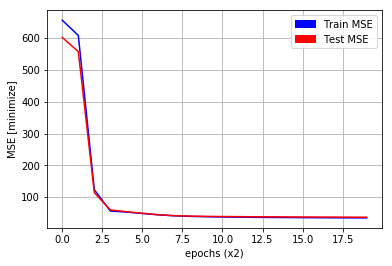

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train MSE')
red_patch = mpatches.Patch(color='red', label='Test MSE')
plt.legend(handles=[blue_patch,red_patch])
plt.grid()

# plot the data
plt.plot(mse_train_list, color='blue')
plt.plot(mse_test_list, color='red')

plt.xlabel('epochs (x{})'.format(display_epoch))
plt.ylabel('MSE [minimize]');